In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# --- 1. Data Loading ---
# Training data (all race data excluding 2024 test data portion)
train_files = glob.glob('2025_future_test_1/**/*.csv', recursive=True)
train_df_list = [pd.read_csv(file) for file in train_files]
train_df = pd.concat(train_df_list, ignore_index=True)

# Test data (specific race data from 2024)
test_files = glob.glob('2025_future_test_1/test_data/2025_austria_RUS_analysis.csv')
test_df_list = [pd.read_csv(file) for file in test_files]
test_df = pd.concat(test_df_list, ignore_index=True)

In [3]:
# --- 2. Preprocessing and Feature Engineering ---

# Define the list of features to be use
# Ordinal categorical features
ordinal_features = ['Compound']
# Nominal categorical features
nominal_features = ['engine']
# Numerical features
numeric_features = [
    'LapNumber', 'tire_laps', 'TrackTemp', 'AirTemp', 'WindDirection',
    'WindSpeed', 'Humidity', 'Circuit_Length', 'corners',
    'low_speed_corners', 'middle_speed_corners', 'high_speed_corners',
    'accelerator_engine', 'RealGap(s)', 'Rainfall'
]
target_feature = 'degradation'

# Integrate the feature lists
features = ordinal_features + nominal_features + numeric_features

# Remove rows containing missing values (consider imputation methods such as mean imputation depending on data conditions)
train_df.dropna(subset=features + [target_feature], inplace=True)
test_df.dropna(subset=features + [target_feature], inplace=True)

# Set explanatory variables and target variable
X_train = train_df[features]
y_train = train_df[target_feature]
X_test = test_df[features]
y_test = test_df[target_feature]


# Define preprocessing pipeline for encoding and scaling
# Define the order of Compound
compound_order = ['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WET']

# Define processing to be applied to each column with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ord', OrdinalEncoder(categories=[compound_order]), ordinal_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ],
    remainder='passthrough' # Columns not specified here will be maintained as-is
)

In [4]:
# --- 3. Model Training and Evaluation ---

# Define the model (Random Forest)
model = RandomForestRegressor(n_estimators=200, max_depth=300, random_state=42)

# Create a pipeline that combines preprocessing and model training
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.012676603742291657
R^2 Score: 0.8288811457934402


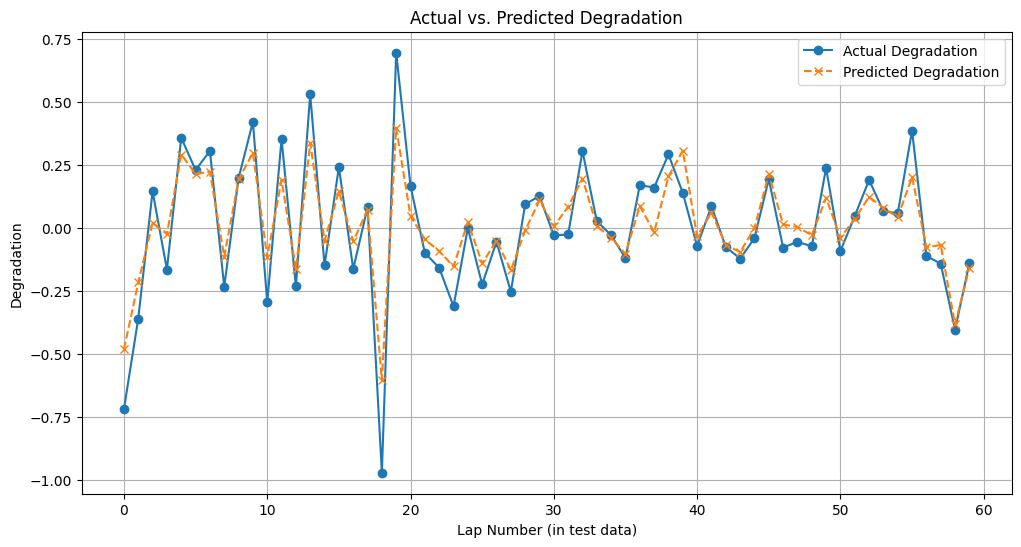

In [5]:
# --- 4. Results Visualization ---

# 1. Comparison plot of actual values vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Degradation', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted Degradation', marker='x', linestyle='--')
plt.xlabel('Lap Number (in test data)')
plt.ylabel('Degradation')
plt.title('Actual vs. Predicted Degradation')
plt.legend()
plt.grid(True)
plt.show()

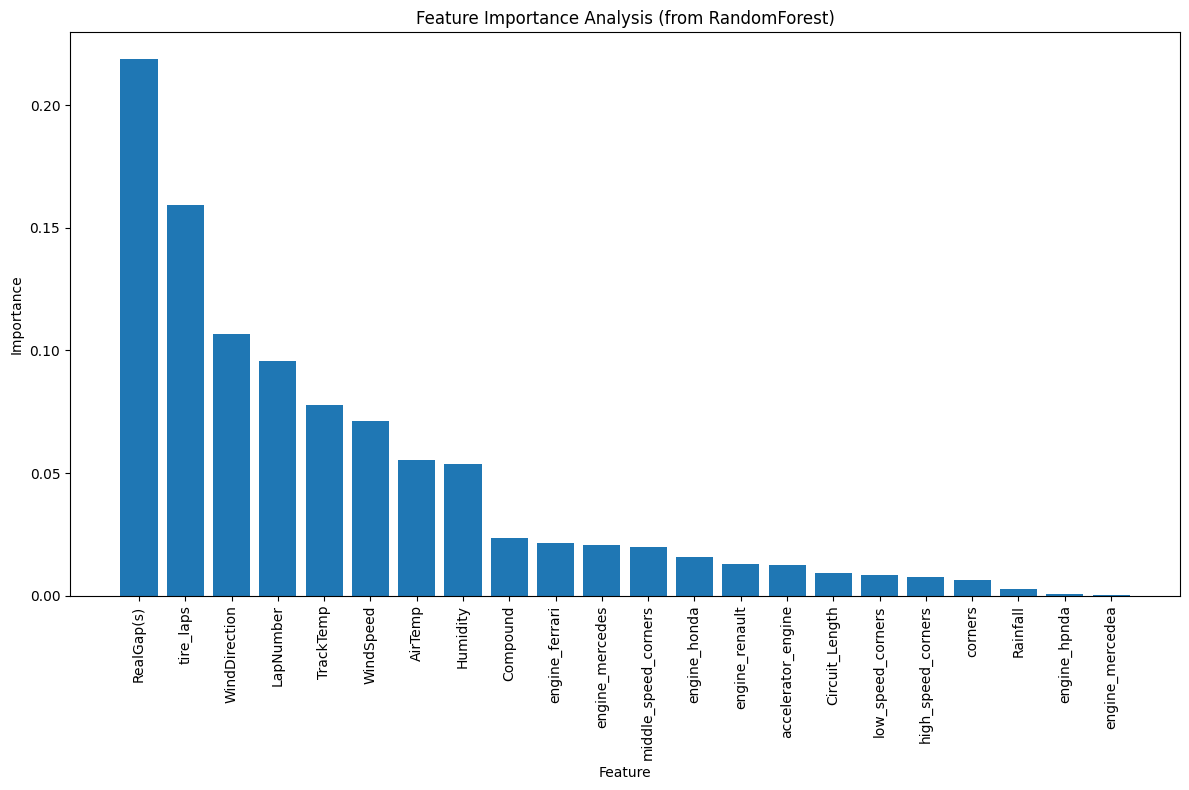

In [6]:
# 2. Feature Importance Visualization
# Obtain feature names after OneHotEncoder transformation from the pipeline
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['nom'].get_feature_names_out(nominal_features)

# Combine all feature names
all_feature_names = numeric_features + ordinal_features + list(ohe_feature_names)

# Extract importance scores from the trained model
importances = pipeline.named_steps['regressor'].feature_importances_

# Organize into a DataFrame
feature_importances = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Analysis (from RandomForest)')
plt.xticks(rotation=90) # Rotate labels 90 degrees
plt.tight_layout() # Adjust layout
plt.show()

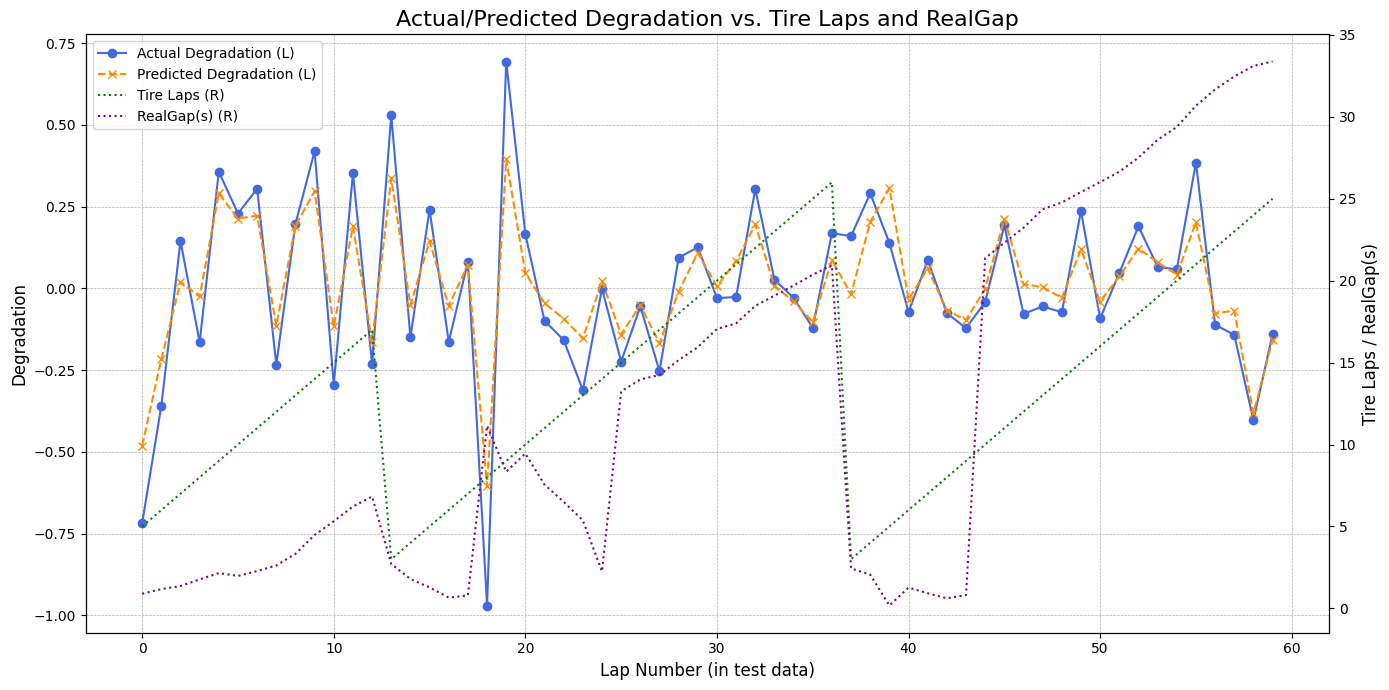

In [7]:
# --- 4. Results Visualization ---

# 1. Plot actual values, predicted values, and other features in an overlay plot (dual-axis graph)

# Create the graph figure (fig) and the first Y-axis (ax1)
fig, ax1 = plt.subplots(figsize=(14, 7))

# --- Plot Degradation on the left Y-axis (ax1) ---
# Actual values
ax1.plot(y_test.values, label='Actual Degradation (L)', marker='o', linestyle='-', color='royalblue')
# Predicted values
ax1.plot(y_pred, label='Predicted Degradation (L)', marker='x', linestyle='--', color='darkorange')

# Set labels and colors for ax1
ax1.set_xlabel('Lap Number (in test data)', fontsize=12)
ax1.set_ylabel('Degradation', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.5) # グリッドを主軸に引く

# --- Plot tire_laps and RealGap(s) on the right Y-axis (ax2) ---
# Create a new Y-axis (ax2) that shares the X-axis with ax1
ax2 = ax1.twinx()

# Retrieve data from X_test (ensure it has the same index as y_test)
ax2.plot(X_test['tire_laps'].values, label='Tire Laps (R)', linestyle=':', color='green')
ax2.plot(X_test['RealGap(s)'].values, label='RealGap(s) (R)', linestyle=':', color='purple')

# Set labels and colors for ax2
ax2.set_ylabel('Tire Laps / RealGap(s)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')


# --- Combine legends into one ---
# Retrieve legend information from both axes and display as a single legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Overall graph title and layout adjustment
plt.title('Actual/Predicted Degradation vs. Tire Laps and RealGap', fontsize=16)
fig.tight_layout()  # Auto-adjust to prevent label overlap
plt.show()